# Основной код

## Данные

### Библиотеки

In [1]:
import boto3
import random
import os
import pandas as pd
from pymorphy2 import MorphAnalyzer
import pickle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nltk
import numpy as np
from tqdm import tqdm

tqdm.pandas()
nltk.download('stopwords')
pd.options.mode.chained_assignment = None
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rjcnz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Скачиваем данные

In [2]:
ACCESS_KEY = ''
SECRET_KEY = ''

In [3]:
BUCKET = "habr-hse"
PATH = "datasets/2023/articles.pkl"

In [4]:
s3_client = boto3.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY
)

In [5]:
%%time

df_orig = pickle.loads(s3_client.get_object(Bucket=BUCKET, Key=PATH).get('Body').read())
len_df_orig = len(df_orig)
print(len_df_orig)
df_orig.head(5)

20000
Wall time: 12.3 s


,id,title,text,time,hubs,tags
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Информационная безопасность *|Платежные систем...,сбер|банкомат|процессинг
1,768038,Code smells — обзор на примере PHP,"Hola, Amigos! Меня зовут Евгений Шмулевский, я...",17 окт в 14:27,PHP *|Программирование *|Совершенный код *,codesmell|php|разработка сайтов|код|программир...
2,768036,Беспарольный вход стал основным для пользовате...,VK ID обновил процесс авторизации пользователе...,17 окт в 14:25,Информационная безопасность *|Социальные сети ...,it-компании|vk id|пароли|вконтакте|соцсети
3,768034,Улучшенная маршрутизация HTTP-серверов в Go 1.22,В Go 1.22 ожидается появление интересного пред...,17 окт в 14:17,Go *,mux|роутинг
4,768032,Xiaomi представила собственную мобильную опера...,Xiaomi выпустит новую операционную систему под...,17 окт в 14:08,Разработка под Android *|Гаджеты |Смартфоны |И...,xiaomi|hyperos|операционные системы|ос|мобильн...


In [6]:
print('Максимум хабов:', df_orig['hubs'].apply(lambda text: len(text.replace('*', '').split('|'))).max())

Максимум хабов: 6


### Формируем качественные данные

In [7]:
df = df_orig.copy()
df['time'] = df['time']
df['tags'] = df['tags'].apply(lambda tags: tags.split('|'))
df['hubs'] = df['hubs'].apply(lambda hubs: hubs.replace('*', '').split('|'))
df_list = []
for i in tqdm(range(len(df))):
    df_i = df.iloc[[i]*len(df[i:i+1]['hubs'].values[0])]
    df_i['hubs'] = [label for label in df_i['hubs'].values[0]]
    df_list.append(df_i)
df = pd.concat(df_list)
print(len(df))
df.head(5)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:03<00:00, 5783.70it/s]


63367


,id,title,text,time,hubs,tags
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Информационная безопасность,"[сбер, банкомат, процессинг]"
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Платежные системы,"[сбер, банкомат, процессинг]"
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,IT-инфраструктура,"[сбер, банкомат, процессинг]"
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Облачные сервисы,"[сбер, банкомат, процессинг]"
0,768040,«Сбер» перевёл свою банкоматную сеть на собств...,17 октября 2023 года «Сбер» сообщил о переводе...,17 окт в 14:36,Финансы в IT,"[сбер, банкомат, процессинг]"


In [8]:
df = df[~df['hubs'].str.contains('Блог компании')]

In [9]:
print(f'В среднем одна статья имеет: {len(df)/len_df_orig} категории')

В среднем одна статья имеет: 2.8193 категории


In [10]:
df['hubs'].value_counts()

IT-компании                     3324
Информационная безопасность     1782
Научно-популярное               1759
Искусственный интеллект         1690
Программирование                1415
                                ... 
Haxe                               1
Silverlight                        1
Magento                            1
I2P                                1
Small Basic                        1
Name: hubs, Length: 403, dtype: int64

In [11]:
min_count = 20
df_val_count = df['hubs'].value_counts()
true_hubs = df_val_count[df_val_count>=min_count].index
df = df[df['hubs'].apply(lambda hub: hub in true_hubs)]
df['hubs'].value_counts()

IT-компании                     3324
Информационная безопасность     1782
Научно-популярное               1759
Искусственный интеллект         1690
Программирование                1415
                                ... 
Монетизация IT-систем             20
WebAssembly                       20
Xcode                             20
Восстановление данных             20
Образование за рубежом            20
Name: hubs, Length: 260, dtype: int64

In [12]:
print(f"Всего уникальных категорий: {len(df['hubs'].unique())}")

Всего уникальных категорий: 260


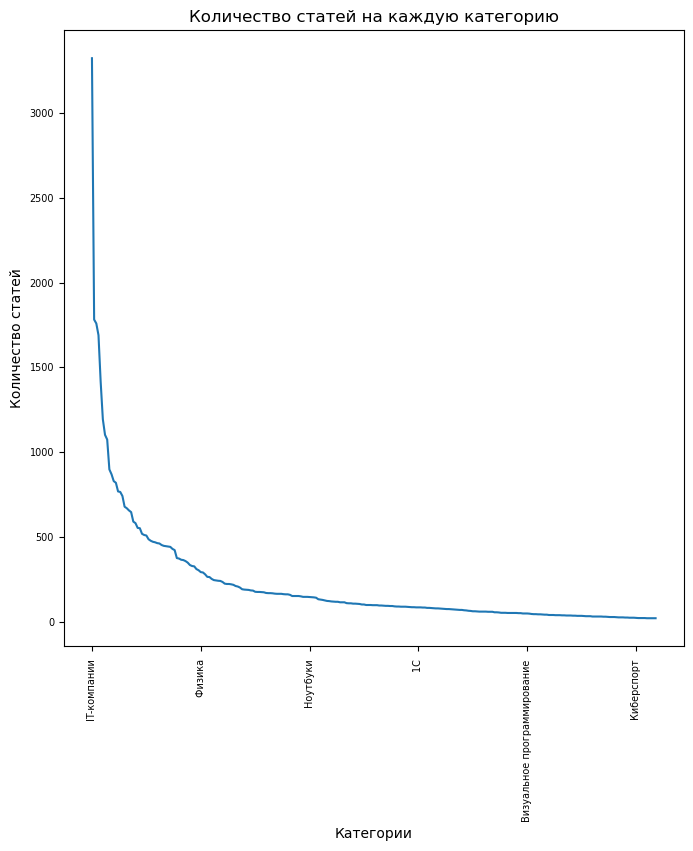

In [13]:
df['hubs'].value_counts().plot(figsize=(8, 8))
plt.xticks(rotation='vertical')
plt.title('Количество статей на каждую категорию')
plt.ylabel('Количество статей')
plt.xlabel('Категории')
plt.tick_params(labelsize = 7)
plt.show()

In [14]:
df['hubs'] = df['hubs'].apply(lambda hub: [hub.strip()])
df = df.groupby('id').agg({'title':'first', 'text':'first', 'time':'first', 'hubs':'sum', 'tags':'first'}).reset_index()
df

,id,title,text,time,hubs,tags
0,720724,Книга «Внутри CPYTHON: гид по интерпретатору P...,"Привет, Хаброжители!\n\nCPython, самая популя...",6 мар в 17:15,"[Python, Профессиональная литература]",[cpyrhon]
1,720726,Продуктовые и фиче-команды,Эта статья наверняка огорчит многих.Я сожалею ...,6 мар в 14:35,[Управление продуктом],"[управление продуктом, product manager, фиче-к..."
2,720730,Как устроен виртуальный помощник для data-серв...,"Привет! Меня зовут Александр, я главный систем...",6 мар в 14:39,"[Big Data, Хранилища данных]","[data governance, metadata, метаданные, управл..."
3,720732,Полный гайд по собеседованиям в IT,В прошлых статьях мы обсудили вход в IT и узна...,6 мар в 14:40,"[Учебный процесс в IT, Карьера в IT-индустрии]","[войти в айти, собеседования, подготовка, джун..."
4,720734,Зависимость вероятности увольнения сотрудников...,По ходу своей работы я давно сделал субъективн...,6 мар в 14:47,"[Управление проектами, Управление персоналом]","[управление людьми, управление проектами и ком..."
...,...,...,...,...,...,...
19701,768032,Xiaomi представила собственную мобильную опера...,Xiaomi выпустит новую операционную систему под...,17 окт в 14:08,"[Разработка под Android, Гаджеты, Смартфоны, И...","[xiaomi, hyperos, операционные системы, ос, мо..."
19702,768034,Улучшенная маршрутизация HTTP-серверов в Go 1.22,В Go 1.22 ожидается появление интересного пред...,17 окт в 14:17,[Go],"[mux, роутинг]"
19703,768036,Беспарольный вход стал основным для пользовате...,VK ID обновил процесс авторизации пользователе...,17 окт в 14:25,"[Информационная безопасность, Социальные сети ...","[it-компании, vk id, пароли, вконтакте, соцсети]"
19704,768038,Code smells — обзор на примере PHP,"Hola, Amigos! Меня зовут Евгений Шмулевский, я...",17 окт в 14:27,"[PHP, Программирование, Совершенный код]","[codesmell, php, разработка сайтов, код, прогр..."


In [15]:
df.to_csv('data/df.csv', index=False)

### Препроцессинг текста

In [16]:
df = pd.read_csv('data/df.csv')

In [17]:
# puncts = '.,"\'?!:;()[]{}<>-–‐—_/\\|*&%$€£¥₽#@^+=~`«»“”‘’0123456789'
# puncts = '.,"\'?!:;()[]{}<>-–‐—_/\\|*&%$€£¥₽#@^+=~`«»“”‘’'
# puncts = '.,"\'?!:()-–‐—`«»“”‘’'
puncts = ''
def del_puncts(text, puncts=puncts):
    return ''.join([symbol if symbol not in puncts else ' ' for symbol in text.replace('\t', ' ').replace('\n', ' ')])

In [18]:
%%time

df['clear_text'] = df['text'].parallel_apply(del_puncts)
df

Wall time: 4.46 s


,id,title,text,time,hubs,tags,clear_text
0,720724,Книга «Внутри CPYTHON: гид по интерпретатору P...,"Привет, Хаброжители!\n\nCPython, самая популя...",6 мар в 17:15,"['Python', 'Профессиональная литература']",['cpyrhon'],"Привет, Хаброжители! CPython, самая популярн..."
1,720726,Продуктовые и фиче-команды,Эта статья наверняка огорчит многих.Я сожалею ...,6 мар в 14:35,['Управление продуктом'],"['управление продуктом', 'product manager', 'ф...",Эта статья наверняка огорчит многих.Я сожалею ...
2,720730,Как устроен виртуальный помощник для data-серв...,"Привет! Меня зовут Александр, я главный систем...",6 мар в 14:39,"['Big Data', 'Хранилища данных']","['data governance', 'metadata', 'метаданные', ...","Привет! Меня зовут Александр, я главный систем..."
3,720732,Полный гайд по собеседованиям в IT,В прошлых статьях мы обсудили вход в IT и узна...,6 мар в 14:40,"['Учебный процесс в IT', 'Карьера в IT-индустр...","['войти в айти', 'собеседования', 'подготовка'...",В прошлых статьях мы обсудили вход в IT и узна...
4,720734,Зависимость вероятности увольнения сотрудников...,По ходу своей работы я давно сделал субъективн...,6 мар в 14:47,"['Управление проектами', 'Управление персоналом']","['управление людьми', 'управление проектами и ...",По ходу своей работы я давно сделал субъективн...
...,...,...,...,...,...,...,...
19701,768032,Xiaomi представила собственную мобильную опера...,Xiaomi выпустит новую операционную систему под...,17 окт в 14:08,"['Разработка под Android', 'Гаджеты', 'Смартфо...","['xiaomi', 'hyperos', 'операционные системы', ...",Xiaomi выпустит новую операционную систему под...
19702,768034,Улучшенная маршрутизация HTTP-серверов в Go 1.22,В Go 1.22 ожидается появление интересного пред...,17 окт в 14:17,['Go'],"['mux', 'роутинг']",В Go 1.22 ожидается появление интересного пред...
19703,768036,Беспарольный вход стал основным для пользовате...,VK ID обновил процесс авторизации пользователе...,17 окт в 14:25,"['Информационная безопасность', 'Социальные се...","['it-компании', 'vk id', 'пароли', 'вконтакте'...",VK ID обновил процесс авторизации пользователе...
19704,768038,Code smells — обзор на примере PHP,"Hola, Amigos! Меня зовут Евгений Шмулевский, я...",17 окт в 14:27,"['PHP', 'Программирование', 'Совершенный код']","['codesmell', 'php', 'разработка сайтов', 'код...","Hola, Amigos! Меня зовут Евгений Шмулевский, я..."


In [19]:
morph = MorphAnalyzer()
morph.parse('ПоЗВонИ')[0].normal_form

'позвонить'

In [20]:
def get_tokens(text, morph=morph):
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split() if word != ''])

In [21]:
%%time

df['tokens_text'] = df['clear_text'].parallel_apply(get_tokens)
df

Wall time: 10min 17s


,id,title,text,time,hubs,tags,clear_text,tokens_text
0,720724,Книга «Внутри CPYTHON: гид по интерпретатору P...,"Привет, Хаброжители!\n\nCPython, самая популя...",6 мар в 17:15,"['Python', 'Профессиональная литература']",['cpyrhon'],"Привет, Хаброжители! CPython, самая популярн...","привет, хаброжители! cpython, самый популярный..."
1,720726,Продуктовые и фиче-команды,Эта статья наверняка огорчит многих.Я сожалею ...,6 мар в 14:35,['Управление продуктом'],"['управление продуктом', 'product manager', 'ф...",Эта статья наверняка огорчит многих.Я сожалею ...,этот статья наверняка огорчить многих.ть сожал...
2,720730,Как устроен виртуальный помощник для data-серв...,"Привет! Меня зовут Александр, я главный систем...",6 мар в 14:39,"['Big Data', 'Хранилища данных']","['data governance', 'metadata', 'метаданные', ...","Привет! Меня зовут Александр, я главный систем...","привет! я звать александр, я главный системный..."
3,720732,Полный гайд по собеседованиям в IT,В прошлых статьях мы обсудили вход в IT и узна...,6 мар в 14:40,"['Учебный процесс в IT', 'Карьера в IT-индустр...","['войти в айти', 'собеседования', 'подготовка'...",В прошлых статьях мы обсудили вход в IT и узна...,в прошлый статья мы обсудить вход в it и узнал...
4,720734,Зависимость вероятности увольнения сотрудников...,По ходу своей работы я давно сделал субъективн...,6 мар в 14:47,"['Управление проектами', 'Управление персоналом']","['управление людьми', 'управление проектами и ...",По ходу своей работы я давно сделал субъективн...,по ход свой работа я давно сделать субъективны...
...,...,...,...,...,...,...,...,...
19701,768032,Xiaomi представила собственную мобильную опера...,Xiaomi выпустит новую операционную систему под...,17 окт в 14:08,"['Разработка под Android', 'Гаджеты', 'Смартфо...","['xiaomi', 'hyperos', 'операционные системы', ...",Xiaomi выпустит новую операционную систему под...,xiaomi выпустить новый операционный система по...
19702,768034,Улучшенная маршрутизация HTTP-серверов в Go 1.22,В Go 1.22 ожидается появление интересного пред...,17 окт в 14:17,['Go'],"['mux', 'роутинг']",В Go 1.22 ожидается появление интересного пред...,в go 1.22 ожидаться появление интересный предл...
19703,768036,Беспарольный вход стал основным для пользовате...,VK ID обновил процесс авторизации пользователе...,17 окт в 14:25,"['Информационная безопасность', 'Социальные се...","['it-компании', 'vk id', 'пароли', 'вконтакте'...",VK ID обновил процесс авторизации пользователе...,vk id обновить процесс авторизация пользовател...
19704,768038,Code smells — обзор на примере PHP,"Hola, Amigos! Меня зовут Евгений Шмулевский, я...",17 окт в 14:27,"['PHP', 'Программирование', 'Совершенный код']","['codesmell', 'php', 'разработка сайтов', 'код...","Hola, Amigos! Меня зовут Евгений Шмулевский, я...","hola, amigos! я звать евгений шмулевский, я ph..."


In [22]:
df.to_csv('data/df.csv', index=False)

### Train-test split

In [23]:
df = pd.read_csv('data/df.csv')

In [24]:
df_train, df_val_test = train_test_split(df,
                                         test_size=0.2,
                                         random_state=42)
df_val, df_test = train_test_split(df_val_test,
                                   test_size=0.5,
                                   random_state=42)

In [25]:
df_train.to_csv('data/df_train.csv', index=False)
df_val.to_csv('data/df_val.csv', index=False)
df_test.to_csv('data/df_test.csv', index=False)

## Метрики

Количество угаданных хабов

In [26]:
def intersection_hubs(true_hubs, pred_hubs):
    intersection = 0
    for hub in true_hubs:
        if hub in pred_hubs:
            intersection += 1
    return intersection

Доля угаданных хабов из топ-k предсказанных

In [27]:
def precision_hubs(true_hubs, pred_hubs):
    intersection = intersection_hubs(true_hubs, pred_hubs)
    precision = intersection / len(pred_hubs)
    return precision

Доля угаданных хабов из возможных

In [28]:
def recall_hubs(true_hubs, pred_hubs):
    len_true_hubs = len(true_hubs)
    if len_true_hubs == 0:
        recall = 1
    else:
        intersection = intersection_hubs(true_hubs, pred_hubs)
        recall = intersection / len_true_hubs
    return recall

Геометрическое среднее двух метрик выше

In [29]:
def f1_score(precision, recall):
    pr_plus_rec = precision + recall
    if pr_plus_rec == 0:
        f1 = 0
    else:
        f1 = 2*precision*recall/pr_plus_rec
    return f1

## Baseline

In [30]:
df_train = pd.read_csv('data/df_train.csv')
df_test = pd.read_csv('data/df_test.csv')
df_train['hubs'] = df_train['hubs'].apply(eval)
df_test['hubs'] = df_test['hubs'].apply(eval)
df_train['tags'] = df_train['tags'].apply(eval)
df_test['tags'] = df_test['tags'].apply(eval)

In [31]:
K = 5

In [32]:
top_k_hubs = pd.Series([i for j in df_train['hubs'].values for i in j]).value_counts().index[:K]
top_k_hubs

Index(['IT-компании', 'Информационная безопасность', 'Научно-популярное',
       'Искусственный интеллект', 'Программирование'],
      dtype='object')

In [33]:
df_test['pred_hubs_base'] = [top_k_hubs.copy() for _ in range(len(df_test))]
df_test['precision_base'] = df_test.apply(lambda row: precision_hubs(row['hubs'], row['pred_hubs_base']), axis=1)
df_test['recall_base'] = df_test.apply(lambda row: recall_hubs(row['hubs'], row['pred_hubs_base']), axis=1)
df_test['f1_base'] = df_test.apply(lambda row: f1_score(row['precision_base'], row['recall_base']), axis=1)
precision_baseline = round(df_test['precision_base'].mean(), 6)
recall_baseline = round(df_test['recall_base'].mean(), 6)
f1_baseline = round(df_test['f1_base'].mean(), 6)

In [34]:
print('Метрики baseline решения:')
print(f'Precision@{K} - {precision_baseline}')
print(f'Recall@{K} - {recall_baseline}')
print(f'F1@{K} - {f1_baseline}')

Метрики baseline решения:
Precision@5 - 0.105429
Recall@5 - 0.191646
F1@5 - 0.130867


In [35]:
df_test.to_csv('data/df_test.csv', index=False)

## Обучение модели

### TF-IDF векторизация

In [36]:
df_train = pd.read_csv('data/df_train.csv')
df_val = pd.read_csv('data/df_val.csv')
df_train['hubs'] = df_train['hubs'].apply(eval)
df_val['hubs'] = df_val['hubs'].apply(eval)
df_train['tags'] = df_train['tags'].apply(eval)
df_val['tags'] = df_val['tags'].apply(eval)

In [37]:
%%time

stop_words = nltk.corpus.stopwords.words("russian")
tfidf_vectorizer = TfidfVectorizer(analyzer='word', min_df=10, stop_words=stop_words)
df_train['tfidf_vec'] = [i for i in tfidf_vectorizer.fit_transform(df_train['tokens_text'].values).toarray()]
df_val['tfidf_vec'] = [i for i in tfidf_vectorizer.transform(df_val['tokens_text'].values).toarray()]
size_vector = len(df_train['tfidf_vec'].values[0])
print(f'Размер tf-idf вектора: {size_vector}')

Размер tf-idf вектора: 47751
Wall time: 13.8 s


In [38]:
with open('data/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

### Neural Network

Dataset

In [39]:
count_hubs = pd.Series([i for j in df_train['hubs'].values for i in j]).value_counts()
all_hubs = count_hubs.index
hub2id = dict(zip(all_hubs, range(len(all_hubs))))
id2hub = {j: i for i, j in hub2id.items()}
num_hubs = len(hub2id)
print(f'Предлагаем из {num_hubs} хабов')

Предлагаем из 260 хабов


In [40]:
def transform_target(hubs):
    vector = np.zeros(num_hubs)
    for hub in hubs:
        vector[hub] = 1
    return vector

In [41]:
class Dataset_hubs(Dataset):
    def __init__(self, df):
        self.vecs = df['tfidf_vec'].values
        self.hubs = df['hubs'].apply(lambda hubs: transform_target([hub2id[hub] for hub in hubs if hub in hub2id])).values
        
    def __getitem__(self, index):
        return self.vecs[index], self.hubs[index]

    def __len__(self):
        return len(self.vecs)

In [42]:
train_data = Dataset_hubs(df_train)
val_data = Dataset_hubs(df_val)

DataLoader

In [43]:
batch_size = 2048
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

Метрики

In [44]:
K = 5

Доля угаданных хабов из топ-k предсказанных

In [45]:
def precision_vectors(y_true, y_pred):
    intersection = y_true@y_pred
    precision = intersection / sum(y_pred)
    return precision

Доля угаданных хабов из возможных

In [46]:
def recall_vectors(y_true, y_pred):
    num_true_hubs = sum(y_true == 1)
    if num_true_hubs == 0:
        recall = 1
    else:
        intersection = y_true@y_pred
        recall = intersection / num_true_hubs
    return recall

Геометрическое среднее двух метрик выше

In [47]:
def f1_score(precision, recall):
    pr_plus_rec = precision + recall
    if pr_plus_rec == 0:
        f1 = 0
    else:
        f1 = 2*precision*recall/pr_plus_rec
    return f1

Модель

In [48]:
class Model_hubs(nn.Module):
    def __init__(self, size_in, size_hide, size_out):
        super().__init__()
        self.linear_1 = nn.Linear(size_in, size_hide)
        self.bn = nn.BatchNorm1d(size_hide)
        self.tanh = nn.Tanh()
        self.dp = nn.Dropout(0.8)
        self.linear_2 = nn.Linear(size_hide, size_out)

        self.tfidf_vectorizer = tfidf_vectorizer
        self.id2hub = id2hub
        
    def forward(self, x):
        x = x.to(torch.float32)
        x = self.linear_1(x)
        x = self.bn(x)
        x = self.tanh(x)
        x = self.dp(x)
        x = self.linear_2(x)
        return x

    def predict(self, text, del_puncts, get_tokens, tfidf_vectorizer, id2hub, k=5, device='cpu'):
        clear_text = del_puncts(text)
        tokens_text = get_tokens(text)
        tfidf_vector = tfidf_vectorizer.transform([text]).toarray()[0]
        output = self.forward(torch.tensor(np.array([tfidf_vector])).to(device)).detach().cpu().numpy()[0]
        preds = np.argsort(output)[::-1][:k]
        scores = output[preds]
        hubs = [id2hub[id_hub] for id_hub in preds]
        return list(zip(hubs, scores))

Фиксация seed

In [49]:
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

Обучение

In [50]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [51]:
size_vector = len(df_train['tfidf_vec'].values[0])
print(f'Размер tf-idf вектора: {size_vector}')

Размер tf-idf вектора: 47751


In [52]:
set_seed(42)
model = Model_hubs(size_in=size_vector, 
                   size_hide=1_000,
                   size_out=num_hubs).to(device)
model.train()

Model_hubs(
  (linear_1): Linear(in_features=47751, out_features=1000, bias=True)
  (bn): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh): Tanh()
  (dp): Dropout(p=0.8, inplace=False)
  (linear_2): Linear(in_features=1000, out_features=260, bias=True)
)

In [53]:
num_params = sum([param.nelement() for param in model.parameters()])
print(f'Количество обучаемых параметров: {num_params}')

Количество обучаемых параметров: 48014260


In [54]:
balance_hubs = count_hubs.values.max() / count_hubs.values

In [55]:
set_seed(42)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor(balance_hubs).float().to(device))

In [56]:
%%time

epochs = 20

set_seed(42)

for epoch_num in range(epochs):
    
    train_loss = 0
    train_pr = 0
    train_rec = 0
    train_f1 = 0
    val_loss = 0
    val_pr = 0
    val_rec = 0
    val_f1 = 0
    
    model.train()
    for data, hubs in tqdm(train_loader):
        data = data.to(device)
        hubs = hubs.to(device)
        output = model(data)
        loss = criterion(output, hubs)
        train_loss += loss.item()
        output = output.detach().cpu().numpy()
        hubs = hubs.detach().cpu().numpy()
        for i in range(len(output)):
            output_i = output[i]
            hubs_i = hubs[i]
            preds = transform_target(np.argsort(output_i)[::-1][:K])
            pr = precision_vectors(hubs_i, preds)
            rec = recall_vectors(hubs_i, preds)
            f1 = f1_score(pr, rec)
            train_pr += pr
            train_rec += rec
            train_f1 += f1
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    model.eval()
    for data, hubs in tqdm(val_loader):
        data = data.to(device)
        hubs = hubs.to(device)
        output = model(data)
        loss = criterion(output, hubs)
        val_loss += loss.item()
        output = output.detach().cpu().numpy()
        hubs = hubs.detach().cpu().numpy()
        for i in range(len(output)):
            output_i = output[i]
            hubs_i = hubs[i]
            preds = transform_target(np.argsort(output_i)[::-1][:K])
            pr = precision_vectors(hubs_i, preds)
            rec = recall_vectors(hubs_i, preds)
            f1 = f1_score(pr, rec)
            val_pr += pr
            val_rec += rec
            val_f1 += f1
        
    train_loss = round(train_loss / len(train_data), 6)
    train_pr = round(train_pr / len(train_data), 6)
    train_rec = round(train_rec / len(train_data), 6)
    train_f1 = round(train_f1 / len(train_data), 6)
    val_loss = round(val_loss / len(val_data), 6)
    val_pr = round(val_pr / len(val_data), 6)
    val_rec = round(val_rec / len(val_data), 6)
    val_f1 = round(val_f1 / len(val_data), 6)
    
    print(
        f"Epochs: {epoch_num + 1} | Train Loss: {train_loss} \
        | Train Precision: {train_pr} | Train Recall: {train_rec} | Train F1: {train_f1} \
        " + "\n" + " "*len(str(epoch_num + 1)) +
f"         | Val Loss: {val_loss}   \
        | Val Precision: {val_pr}   | Val Recall: {val_rec}   | Val F1: {val_f1}")

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.13s/it]


Epochs: 1 | Train Loss: 0.093935         | Train Precision: 0.189457 | Train Recall: 0.361639 | Train F1: 0.238484         
          | Val Loss: 0.113176           | Val Precision: 0.284932   | Val Recall: 0.532657   | Val F1: 0.356826


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


Epochs: 2 | Train Loss: 0.059718         | Train Precision: 0.305925 | Train Recall: 0.581008 | Train F1: 0.384256         
          | Val Loss: 0.090949           | Val Precision: 0.342466   | Val Recall: 0.640732   | Val F1: 0.429054


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


Epochs: 3 | Train Loss: 0.050854         | Train Precision: 0.344329 | Train Recall: 0.65159 | Train F1: 0.432009         
          | Val Loss: 0.075984           | Val Precision: 0.370878   | Val Recall: 0.689946   | Val F1: 0.463987


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


Epochs: 4 | Train Loss: 0.048499         | Train Precision: 0.369931 | Train Recall: 0.69866 | Train F1: 0.463952         
          | Val Loss: 0.06966           | Val Precision: 0.376662   | Val Recall: 0.70115   | Val F1: 0.471277


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


Epochs: 5 | Train Loss: 0.047681         | Train Precision: 0.384636 | Train Recall: 0.72471 | Train F1: 0.48219         
          | Val Loss: 0.069985           | Val Precision: 0.379604   | Val Recall: 0.707695   | Val F1: 0.475134


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


Epochs: 6 | Train Loss: 0.046061         | Train Precision: 0.398757 | Train Recall: 0.750491 | Train F1: 0.499683         
          | Val Loss: 0.07118           | Val Precision: 0.381532   | Val Recall: 0.708625   | Val F1: 0.47721


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Epochs: 7 | Train Loss: 0.045483         | Train Precision: 0.411 | Train Recall: 0.772668 | Train F1: 0.514959         
          | Val Loss: 0.071818           | Val Precision: 0.384678   | Val Recall: 0.716176   | Val F1: 0.481288


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.00s/it]


Epochs: 8 | Train Loss: 0.0441         | Train Precision: 0.417445 | Train Recall: 0.784824 | Train F1: 0.523062         
          | Val Loss: 0.072753           | Val Precision: 0.387418   | Val Recall: 0.720869   | Val F1: 0.484475


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


Epochs: 9 | Train Loss: 0.042749         | Train Precision: 0.426491 | Train Recall: 0.798723 | Train F1: 0.533885         
          | Val Loss: 0.071476           | Val Precision: 0.38762   | Val Recall: 0.721546   | Val F1: 0.484876


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.05s/it]


Epochs: 10 | Train Loss: 0.041555         | Train Precision: 0.43135 | Train Recall: 0.80733 | Train F1: 0.539778         
           | Val Loss: 0.07191           | Val Precision: 0.391071   | Val Recall: 0.72842   | Val F1: 0.48922


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


Epochs: 11 | Train Loss: 0.040042         | Train Precision: 0.441855 | Train Recall: 0.82497 | Train F1: 0.552644         
           | Val Loss: 0.071227           | Val Precision: 0.391679   | Val Recall: 0.728311   | Val F1: 0.489619


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


Epochs: 12 | Train Loss: 0.038885         | Train Precision: 0.446448 | Train Recall: 0.83264 | Train F1: 0.558148         
           | Val Loss: 0.071134           | Val Precision: 0.391476   | Val Recall: 0.727727   | Val F1: 0.48942


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


Epochs: 13 | Train Loss: 0.037654         | Train Precision: 0.456648 | Train Recall: 0.848873 | Train F1: 0.570372         
           | Val Loss: 0.071271           | Val Precision: 0.393201   | Val Recall: 0.731727   | Val F1: 0.491729


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.01s/it]


Epochs: 14 | Train Loss: 0.0366         | Train Precision: 0.459896 | Train Recall: 0.853166 | Train F1: 0.57401         
           | Val Loss: 0.070472           | Val Precision: 0.394825   | Val Recall: 0.735819   | Val F1: 0.494058


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.20s/it]


Epochs: 15 | Train Loss: 0.035616         | Train Precision: 0.467204 | Train Recall: 0.864638 | Train F1: 0.582703         
           | Val Loss: 0.070042           | Val Precision: 0.396753   | Val Recall: 0.737198   | Val F1: 0.495861


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


Epochs: 16 | Train Loss: 0.0345         | Train Precision: 0.47101 | Train Recall: 0.870213 | Train F1: 0.587081         
           | Val Loss: 0.069993           | Val Precision: 0.394521   | Val Recall: 0.732259   | Val F1: 0.492942


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]


Epochs: 17 | Train Loss: 0.033614         | Train Precision: 0.476744 | Train Recall: 0.879454 | Train F1: 0.594054         
           | Val Loss: 0.070896           | Val Precision: 0.395941   | Val Recall: 0.736251   | Val F1: 0.495029


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.04s/it]


Epochs: 18 | Train Loss: 0.033492         | Train Precision: 0.482098 | Train Recall: 0.887605 | Train F1: 0.600282         
           | Val Loss: 0.070907           | Val Precision: 0.397565   | Val Recall: 0.739346   | Val F1: 0.497038


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.00it/s]


Epochs: 19 | Train Loss: 0.033145         | Train Precision: 0.48527 | Train Recall: 0.892572 | Train F1: 0.604054         
           | Val Loss: 0.070511           | Val Precision: 0.396449   | Val Recall: 0.735743   | Val F1: 0.495274


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.03s/it]

Epochs: 20 | Train Loss: 0.03233         | Train Precision: 0.488708 | Train Recall: 0.897408 | Train F1: 0.608006         
           | Val Loss: 0.070613           | Val Precision: 0.39929   | Val Recall: 0.739819   | Val F1: 0.498694
Wall time: 3min 20s


In [57]:
torch.save(model, "data/model.pth")

In [58]:
with open('data/id2hub.pkl', 'wb') as f:
    pickle.dump(id2hub, f)

## Тест модели

In [59]:
model = torch.load('data/model.pth')
df_train = pd.read_csv('data/df_train.csv')
df_val = pd.read_csv('data/df_val.csv')
df_test = pd.read_csv('data/df_test.csv')
df_train['hubs'] = df_train['hubs'].apply(eval)
df_val['hubs'] = df_val['hubs'].apply(eval)
df_test['hubs'] = df_test['hubs'].apply(eval)
df_train['tags'] = df_train['tags'].apply(eval)
df_val['tags'] = df_val['tags'].apply(eval)
df_test['tags'] = df_test['tags'].apply(eval)
with open('data/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)
with open('data/id2hub.pkl', 'rb') as f:
    id2hub = pickle.load(f)

In [60]:
# puncts = '.,"\'?!:;()[]{}<>-–‐—_/\\|*&%$€£¥₽#@^+=~`«»“”‘’0123456789'
# puncts = '.,"\'?!:;()[]{}<>-–‐—_/\\|*&%$€£¥₽#@^+=~`«»“”‘’'
# puncts = '.,"\'?!:()-–‐—`«»“”‘’'
puncts = ''
def del_puncts(text, puncts=puncts):
    return ''.join([symbol if symbol not in puncts else ' ' for symbol in text.replace('\t', ' ').replace('\n', ' ')])

In [61]:
morph = MorphAnalyzer()
def get_tokens(text, morph=morph):
    return ' '.join([morph.parse(word)[0].normal_form for word in text.split() if word != ''])

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [63]:
K=5

До этого метрики считались только по num_hubs предсказываемым хабам

Фактические метрики на тестовой выборке:

In [64]:
df_test['pred_hubs_nn'] = df_test['text'].progress_apply(lambda text: model.predict(text, 
                                                                               del_puncts, 
                                                                               get_tokens, 
                                                                               tfidf_vectorizer, 
                                                                               id2hub, 
                                                                               K, 
                                                                               device))
df_test['pred_scores_nn'] = df_test['pred_hubs_nn'].apply(lambda hubs_scores: [hub_score[1] for hub_score in hubs_scores])
df_test['pred_hubs_nn'] = df_test['pred_hubs_nn'].apply(lambda hubs_scores: [hub_score[0] for hub_score in hubs_scores])

100%|██████████████████████████████████████████████████████████████████████████████| 1971/1971 [05:16<00:00,  6.23it/s]


In [65]:
df_test['precision_nn'] = df_test.apply(lambda row: precision_hubs(row['hubs'], row['pred_hubs_nn']), axis=1)
df_test['recall_nn'] = df_test.apply(lambda row: recall_hubs(row['hubs'], row['pred_hubs_nn']), axis=1)
df_test['f1_nn'] = df_test.apply(lambda row: f1_score(row['precision_nn'], row['recall_nn']), axis=1)
precision_baseline = round(df_test['precision_nn'].mean(), 6)
recall_baseline = round(df_test['recall_nn'].mean(), 6)
f1_baseline = round(df_test['f1_nn'].mean(), 6)

In [66]:
print('Метрики Neural Network решения:')
print(f'Precision@{K} - {precision_baseline}')
print(f'Recall@{K} - {recall_baseline}')
print(f'F1@{K} - {f1_baseline}')

Метрики Neural Network решения:
Precision@5 - 0.392288
Recall@5 - 0.725266
F1@5 - 0.48851


In [67]:
df_test.to_csv('data/df_test.csv', index=False)

Случайный пример

In [68]:
i_test = 1
test_i = df_test[['text', 'hubs']].values[i_test]
test_text_i = test_i[0]
test_hubs_i = test_i[1]
print(test_text_i)
print(test_hubs_i)

Частная космическая компания Relativity Space планирует отказаться от использования напечатанной на 3D-принтере ракеты Terran 1 спустя несколько недель после первых испытаний носителя. Производитель намерен сосредоточиться на запусках более крупной ракеты Terran R в надежде удовлетворить потребности рынка и успешнее конкурировать с лидером отрасли — SpaceX.Relativity впервые запустила Terran 1 22 марта, однако ракета не смогла достичь орбиты из-за отказа двигателя. Переход на использование Terran R означает, что компания не будет проводить дополнительные старты до 2026 года, пока ракета не будет готова к полёту.Главный исполнительный директор Relativity Тим Эллис назвал это решение «очевидным выбором», поскольку запуски больших грузов сейчас пользуются повышенным спросом. Он считает, что «на рынке просто нет хороших решений».Компания сообщила о разработке Terran R в 2021 году. По словам Эллиса, большинство клиентов Relativity оказались довольны изменением направления, они согласились п

In [69]:
model.predict(test_text_i, del_puncts, get_tokens, tfidf_vectorizer, id2hub, K, device)

[('Космонавтика', 6.967836),
 ('Научно-популярное', 4.765517),
 ('Будущее здесь', 4.26546),
 ('IT-компании', 4.245879),
 ('Производство и разработка электроники', 4.1883025)]